In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Mon Jan 15 20:45:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   23C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 39%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_mmd_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

opts = {'pz_scale': 1,
        'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
        'pz': 'uniform', # 'normal', 'sphere', 'uniform'
        'zdim': hp.z_dim
       }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.14-13/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 4
-rw-rw-r-- 1 scpark scpark 40  1월 15 20:45 events.out.tfevents.1705318838.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


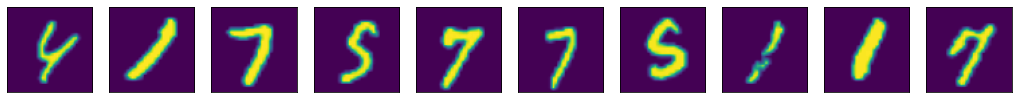

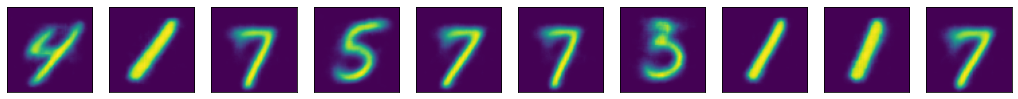

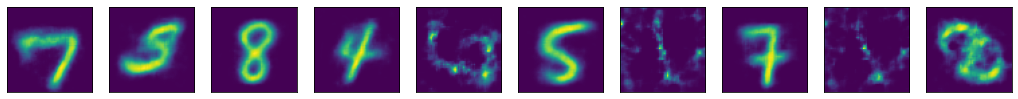

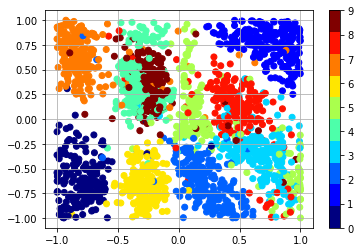

17001
mmd_loss -0.00010925531387329102
recon_loss 0.09968664050102234
17002
mmd_loss -0.0004072070121765137
recon_loss 0.09529336914420128
17003
mmd_loss -0.00034171342849731445
recon_loss 0.09424892514944076
17004
mmd_loss -0.0005307435989379883
recon_loss 0.09818880558013916
17005
mmd_loss -0.000650489330291748
recon_loss 0.09508170783519745
17006
mmd_loss -2.5796890258789063e-05
recon_loss 0.09358009845018386
17007
mmd_loss -0.00022091865539550782
recon_loss 0.10354821532964706
17008
mmd_loss 0.00010778903961181641
recon_loss 0.10307662189006805
17009
mmd_loss -0.0006682634353637696
recon_loss 0.0989605113863945
17010
mmd_loss -0.0006762385368347168
recon_loss 0.09668674618005753
17011
mmd_loss 0.0011072635650634765
recon_loss 0.10220702812075615
17012
mmd_loss 0.0004135727882385254
recon_loss 0.09498444274067878
17013
mmd_loss -0.0007738947868347168
recon_loss 0.10093661472201347
17014
mmd_loss 5.7196617126464845e-05
recon_loss 0.10024819523096085
17015
mmd_loss 0.00055515766143798

mmd_loss 0.00018934011459350585
recon_loss 0.10039935186505318
17122
mmd_loss -0.00042299032211303713
recon_loss 0.09659134522080422
17123
mmd_loss 0.0004946827888488769
recon_loss 0.09950551837682724
17124
mmd_loss -0.0008141398429870605
recon_loss 0.0964931957423687
17125
mmd_loss -0.0006210565567016602
recon_loss 0.10154154151678085
17126
mmd_loss -0.0008617877960205078
recon_loss 0.09475086256861687
17127
mmd_loss -0.00021969079971313478
recon_loss 0.10156254544854164
17128
mmd_loss -0.0008931398391723633
recon_loss 0.09339607208967209
17129
mmd_loss -0.0005005598068237305
recon_loss 0.1013397715985775
17130
mmd_loss -0.0003306746482849121
recon_loss 0.09551751911640168
17131
mmd_loss -0.0006862759590148925
recon_loss 0.09803562760353088
17132
mmd_loss 0.0012363553047180175
recon_loss 0.09192897230386735
17133
mmd_loss -0.0001598477363586426
recon_loss 0.09906674921512604
17134
mmd_loss 0.00028744935989379885
recon_loss 0.09410173967480659
17135
mmd_loss 0.00022450685501098632
reco

mmd_loss -0.000908064842224121
recon_loss 0.09755582958459855
17242
mmd_loss -0.0004977941513061524
recon_loss 0.09705450609326363
17243
mmd_loss -0.000965416431427002
recon_loss 0.10313762351870537
17244
mmd_loss 0.002485477924346924
recon_loss 0.09472364857792855
17245
mmd_loss -0.00027478933334350585
recon_loss 0.09275026023387908
17246
mmd_loss -0.0006820082664489747
recon_loss 0.09300453886389733
17247
mmd_loss 2.969503402709961e-05
recon_loss 0.09698417037725449
17248
mmd_loss 0.00181809663772583
recon_loss 0.091693564504385
17249
mmd_loss 0.0025864243507385254
recon_loss 0.10635940283536911
17250
mmd_loss -8.7738037109375e-06
recon_loss 0.0969325251877308
17251
mmd_loss 0.00020625591278076172
recon_loss 0.0989707924425602
17252
mmd_loss -0.0009361982345581054
recon_loss 0.10044730752706528
17253
mmd_loss -0.0011248230934143067
recon_loss 0.10175252258777619
17254
mmd_loss -0.000630497932434082
recon_loss 0.09698672890663147
17255
mmd_loss -0.0008471250534057617
recon_loss 0.0975

mmd_loss 0.0018765687942504882
recon_loss 0.09229585751891137
17362
mmd_loss -4.798173904418945e-05
recon_loss 0.1002080999314785
17363
mmd_loss -7.064342498779297e-05
recon_loss 0.09996769204735756
17364
mmd_loss -0.0008406400680541992
recon_loss 0.10137487873435021
17365
mmd_loss -0.0005743265151977539
recon_loss 0.09361937344074249
17366
mmd_loss -0.0006515860557556152
recon_loss 0.09669848531484604
17367
mmd_loss -0.0007528424263000488
recon_loss 0.09618808776140213
17368
mmd_loss -0.0006966948509216309
recon_loss 0.08961432129144668
17369
mmd_loss -0.0007309556007385254
recon_loss 0.10082954168319702
17370
mmd_loss 0.0001633763313293457
recon_loss 0.09104459509253501
17371
mmd_loss -0.000689554214477539
recon_loss 0.10115600153803825
17372
mmd_loss 0.0002476692199707031
recon_loss 0.09509456679224967
17373
mmd_loss 7.135868072509766e-05
recon_loss 0.0980922095477581
17374
mmd_loss -0.0001695990562438965
recon_loss 0.09809533581137657
17375
mmd_loss -0.00010015964508056641
recon_lo

mmd_loss -0.0006190180778503418
recon_loss 0.09666962027549744
17482
mmd_loss -0.0009635448455810547
recon_loss 0.10087282955646515
17483
mmd_loss -0.000231015682220459
recon_loss 0.10485078021883965
17484
mmd_loss -0.0005219817161560058
recon_loss 0.09665871113538742
17485
mmd_loss -0.0008180379867553711
recon_loss 0.09841747283935547
17486
mmd_loss -0.00026115179061889646
recon_loss 0.09662847444415093
17487


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, opts=opts)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        